# Grapher

## Dataset

- `id`: This column represents the id of the variant in the following format: #chrom:pos:ref:alt (string).

- `#chrom`: This column represents the chromosome number where the genetic variant is located.

- `pos`: This is the position of the genetic variant on the chromosome.

- `ref`: This column represents the reference allele (or variant) at the genomic position.

- `alt`: This is the alternate allele observed at this position.

- `rsids`: This stands for reference SNP cluster ID. It's a unique identifier for each variant used in the dbSNP database.

- `nearest_genes`: This column represents the gene which is nearest to the variant.

- `pval`: This represents the p-value, which is a statistical measure for the strength of evidence against the null hypothesis.

- `mlogp`: This represents the minus log of the p-value, commonly used in genomic studies.

- `beta`: The beta coefficient represents the effect size of the variant.

- `sebeta`: This is the standard error of the beta coefficient.

- `af_alt`: This is the allele frequency of the alternate variant in the general population.

- `af_alt_cases`: This is the allele frequency of the alternate variant in the cases group.

- `af_alt_controls`: This is the allele frequency of the alternate variant in the control group.

- `finemapped`: This column represents whether the variant is included in the post-finemapped dataset (1) or not (0). 

- `trait`: This column represents the trait associated with the variant. In this dataset, it is the response to the drug paracetamol and NSAIDs.

## Load libraries

In [1]:
import sys
import os
import random
import numpy as np
from numba import jit, prange
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import to_undirected, negative_sampling
import networkx as nx
from scipy.spatial import cKDTree
from scipy.special import expit
from typing import List, Dict
import time
import cProfile
import pstats
import io
import category_encoders as ce
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import copy
from torch_geometric.transforms import RandomNodeSplit
from collections import Counter
from category_encoders import BinaryEncoder
import cProfile
import pstats
import io



# Print versions of imported libraries
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Torch Geometric version: {torch_geometric.__version__}")
print(f"NetworkX version: {nx.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda")          # Current CUDA device
    print(f"Using {torch.cuda.get_device_name()} ({device})")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
else:
    print("CUDA is not available on this device.")

Python version: 3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]
NumPy version: 1.24.3
Pandas version: 2.0.1
Matplotlib version: 3.7.1
Scikit-learn version: 1.2.2
Torch version: 2.0.0+cu118
Torch Geometric version: 2.3.1
NetworkX version: 3.0
Using NVIDIA GeForce RTX 3060 Ti (cuda)
CUDA version: 11.8
Number of CUDA devices: 1


## Load data

In [2]:
dtypes = {
    'id': 'string',
    '#chrom': 'int64',
    'pos': 'int64',
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': 'float64',
    'mlogp': 'float64',
    'beta': 'float64',
    'sebeta': 'float64',
    'af_alt': 'float64',
    'af_alt_cases': 'float64',
    'af_alt_controls': 'float64',
    'finemapped': 'int64'
}

data = pd.read_csv('~/Desktop/gwas-graph/FinnGen/data/gwas-finemap.csv', dtype=dtypes)

# Assert column names
expected_columns = ['#chrom', 'pos', 'ref', 'alt', 'rsids', 'nearest_genes', 'pval', 'mlogp', 'beta',
                    'sebeta', 'af_alt', 'af_alt_cases', 'af_alt_controls', 'finemapped',
                    'id', 'trait']
assert set(data.columns) == set(expected_columns), "Unexpected columns in the data DataFrame."

# Assert data types
expected_dtypes = {
    'id': 'string',
    '#chrom': 'int64',
    'pos': 'int64',
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': 'float64',
    'mlogp': 'float64',
    'beta': 'float64',
    'sebeta': 'float64',
    'af_alt': 'float64',
    'af_alt_cases': 'float64',
    'af_alt_controls': 'float64',
    'finemapped': 'int64'
}

for col, expected_dtype in expected_dtypes.items():
    assert data[col].dtype == expected_dtype, f"Unexpected data type for column {col}."

In [3]:
# Check for total number of null values in each column
null_counts = data.isnull().sum()

print("Total number of null values in each column:")
print(null_counts)

Total number of null values in each column:
#chrom                   0
pos                      0
ref                      0
alt                      0
rsids              1366396
nearest_genes       727855
pval                     0
mlogp                    0
beta                     0
sebeta                   0
af_alt                   0
af_alt_cases             0
af_alt_controls          0
id                       0
finemapped               0
trait                    0
dtype: int64


## Data manipulation

In [4]:
data = data.sample(frac=0.01, random_state=42)

### Find nearest gene

In [5]:
data['nearest_genes'] = data['nearest_genes'].astype(str)

# Assert column 'nearest_genes' is a string
assert data['nearest_genes'].dtype == 'object', "Column 'nearest_genes' is not of string type."

# Get the length of the data before transformation
original_length = len(data)

# Extract the first gene name from the 'nearest_genes' column
data['nearest_genes'] = data['nearest_genes'].str.split(',').str[0]

# Reset index to have a standard index
data = data.reset_index(drop=True)

# Assert the length of the data remains the same
assert len(data) == original_length, "Length of the data has changed after transformation."

## Spec

### Data

`data` Pandas DataFrame:

- `id`: This column represents the id of the variant in the following format: #chrom:pos:ref:alt (string).
- `#chrom`: This column represents the chromosome number where the genetic variant is located (int).
- `pos`: This is the position of the genetic variant on the chromosome (int: 1-200,000).
- `ref`: This column represents the reference allele (or variant) at the genomic position.
- `alt`: This is the alternate allele observed at this position.
- `rsids`: This stands for reference SNP cluster ID. It's a unique identifier for each variant used in the dbSNP database.
- `nearest_genes`: This column represents the gene which is nearest to the variant (string).
- `pval`: This represents the p-value, which is a statistical measure for the strength of evidence against the null hypothesis.
- `mlogp`: This represents the minus log of the p-value, commonly used in genomic studies.
- `beta`: The beta coefficient represents the effect size of the variant.
- `sebeta`: This is the standard error of the beta coefficient.
- `af_alt`: This is the allele frequency of the alternate variant in the general population (float: 0-1.
- `af_alt_cases`: This is the allele frequency of the alternate variant in the cases group (float: 0-1).
- `af_alt_controls`: This is the allele frequency of the alternate variant in the control group (float: 0-1).
- `finemapped`: This column represents whether the variant is included in the post-finemapped dataset (1) or not (0) (int).
- `trait`: This column represents the trait associated with the variant. In this dataset, it is the response to the drug paracetamol and NSAIDs.

### Task Overview

The objective is to design and implement a binary node classification GNN model to predict whether variants are included after post-finemapping or not based on `finemapping`.

### Nodes and Their Features

There is one type of node: SNP nodes.

- **SNP Nodes**: Each SNP Node is characterized by various features, including `id`, `nearest_genes`, `#chrom`, `pos`, `ref`, `alt`, `mlogp`, `beta`, `sebeta`,  `af_alt`, `af_alt_cases`, and `af_alt_controls` columns.

### Edges, Their Features, and Labels

Edges represent relationships between SNP nodes in the graph:

- For each pair of SNPs (row1 and row2) that exist on the same chromosome (`#chrom`), an edge is created if the absolute difference between their positions (`pos`) is less than or equal to 1,000,000 and greater than 1 (no loops).
-  Create a new edge attribute called `LD` for each edge. The value of `LD` is determined by the following formula:
     
```
weights = 1 * e^(-ln(2) / 100_000 * pos_diff_abs)
```

- The edge attributes (`edge_attr`) are:
   - `nearest_genes` 
   - `#chrom`
   - `pos`
   - `af_alt`, 
   - `af_alt_cases` 
   - `af_alt_controls`
   - `LD`

## Graph creation

In [6]:
from math import exp, log

edge_weight_cutoff = 1e-3  # set the cutoff value



def get_unique_snps(data: pd.DataFrame) -> dict:
    return {snp: idx for idx, snp in enumerate(data['id'].unique())}



def preprocess_snp_features(data: pd.DataFrame, snp_to_idx: dict) -> pd.DataFrame:
    cols_to_extract = ['id', 'nearest_genes', '#chrom', 'pos', 'ref', 'alt', 'mlogp', 'beta', 'sebeta', 'af_alt', 'af_alt_cases', 'af_alt_controls']
    snp_features = data.loc[data['id'].isin(snp_to_idx.keys()), cols_to_extract].set_index('id').sort_index()

    scaler = RobustScaler()

    categorical_cols = ['ref', 'alt', 'nearest_genes']
    count_encoder = ce.CountEncoder(cols=categorical_cols)
    snp_features = count_encoder.fit_transform(snp_features)

    numerical_cols = list(set(snp_features.columns) - set(categorical_cols))
    #snp_features[numerical_cols] = scaler.fit_transform(snp_features[numerical_cols])

    snp_features = snp_features.fillna(0)

    return snp_features



def preprocess_edges(data: pd.DataFrame, snp_to_idx: dict) -> torch.Tensor:
    scaler = RobustScaler()
    
    data = data.sort_values(by=['#chrom', 'pos'])
    data['snp_idx'] = data['id'].map(snp_to_idx)
    
    label_encoder = LabelEncoder()
    data['nearest_genes'] = label_encoder.fit_transform(data['nearest_genes'])
    
    edge_list = []
    edge_attributes = []

    for chrom, group in data.groupby('#chrom'):
        if group.empty:
            continue
        
        # We can use broadcasting to create a matrix of differences, this avoids the inner loop
        pos_diff = abs(group['pos'].values[:, None] - group['pos'].values)
        mask = (pos_diff > 1) & (pos_diff <= 1_000_000)

        filtered_group = group[mask]
        
        if filtered_group.empty:
            continue
        
        edge_list.extend([(idx, other_idx) for idx, others in enumerate(mask) for other_idx in others.nonzero()[0]])
        
        edge_attr = np.vstack([filtered_group['nearest_genes'].values,
                               filtered_group['#chrom'].values,
                               filtered_group['pos'].values,
                               filtered_group['af_alt'].values,
                               filtered_group['af_alt_cases'].values,
                               filtered_group['af_alt_controls'].values,
                               np.exp(-np.log(2) / 100_000 * pos_diff[mask])]).T
                               
        edge_attributes.append(edge_attr)

    edge_attributes = np.vstack(edge_attributes)
    edge_attributes = scaler.fit_transform(edge_attributes)
    
    return torch.tensor(edge_list, dtype=torch.long).t().contiguous(), torch.tensor(edge_attributes, dtype=torch.float)


def create_pytorch_graph(features: torch.Tensor, edges: torch.Tensor, edge_attr: torch.Tensor) -> Data:
    return Data(x=features, edge_index=edges, edge_attr=edge_attr)



# Create a profiler object
pr = cProfile.Profile()
pr.enable()

start_time = time.time()

snp_to_idx = get_unique_snps(data)
snp_features = preprocess_snp_features(data, snp_to_idx)
features = torch.tensor(snp_features.values, dtype=torch.float)

edges, edge_attr = preprocess_edges(data, snp_to_idx)
graph = create_pytorch_graph(features, edges, edge_attr)
graph.y = torch.tensor(data['finemapped'].values, dtype=torch.long)

print(f"Number of nodes: {graph.num_nodes}")
print(f"Number of edges: {graph.num_edges}")
print(f"Node feature dimension: {graph.num_node_features}")

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Execution time: {elapsed_time} seconds")

pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats(3)  # Only print the top 3 lines
print(s.getvalue())


Number of nodes: 201700
Number of edges: 29228030
Node feature dimension: 11
Execution time: 29.26963710784912 seconds
         7673643 function calls (7672252 primitive calls) in 28.815 seconds

   Ordered by: cumulative time
   List reduced from 1060 to 3 due to restriction <3>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       13    0.000    0.000   29.269    2.251 C:\Users\falty\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3472(run_code)
       13    0.000    0.000   29.268    2.251 {built-in method builtins.exec}
        1    7.554    7.554   26.731   26.731 C:\Users\falty\AppData\Local\Temp\ipykernel_24728\3508914266.py:31(preprocess_edges)





tensor([2340, 2340, 2341,  ..., 2091, 2091, 2091])
Number of clusters: 2907


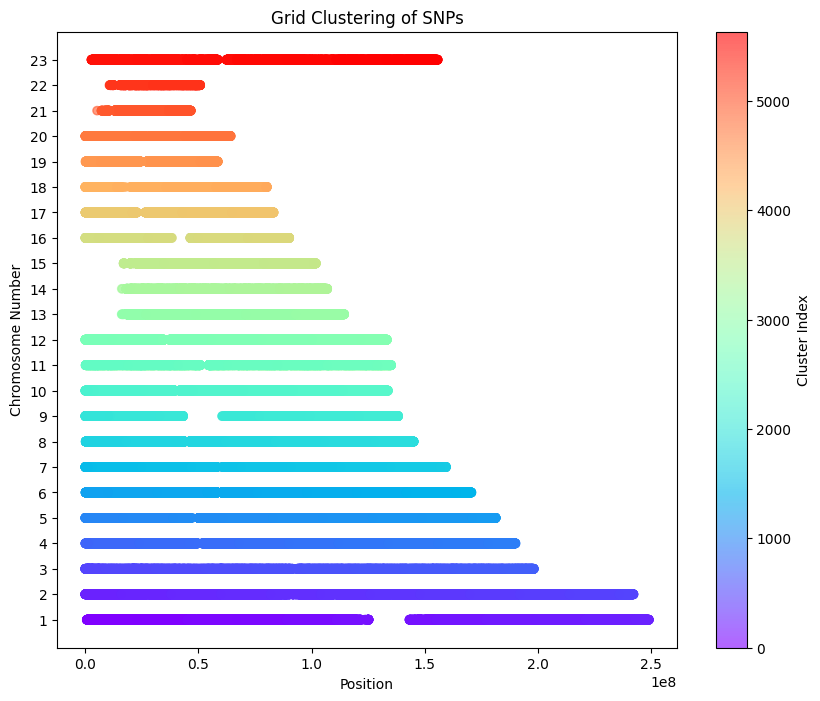

In [13]:
from torch_cluster import grid_cluster
import matplotlib.colors as mcolors

# Assume pos_chrom is a tensor of shape [num_nodes, 2], 
# where the first column represents 'pos' and the second column represents '#chrom'
pos_chrom = torch.tensor(np.stack([snp_features['pos'].values, snp_features['#chrom'].values])).t()

# Define the size of the grid cells. You may want to adjust this according to your needs.
size = torch.tensor([1e6, 1])  # Creates a grid with cell size defined according to your data distribution

# Perform the grid clustering
cluster = grid_cluster(pos_chrom, size)

# Now, cluster is a tensor of size [num_nodes] where each element is the cluster index of the corresponding node
print(cluster)

# Get the 'pos' and '#chrom' data
x = pos_chrom[:, 0].numpy()  # extract 'pos'
y = pos_chrom[:, 1].numpy()  # extract '#chrom'

# Convert cluster tensor to numpy for use with matplotlib
cluster = cluster.numpy()

num_clusters = len(np.unique(cluster))
print("Number of clusters:", num_clusters)

# Create a colormap based on the number of unique clusters
cmap = mcolors.LinearSegmentedColormap.from_list('rainbow', plt.cm.rainbow(np.linspace(0, 1, len(np.unique(cluster)))))

plt.figure(figsize=(10, 8))
sc = plt.scatter(x, y, c=cluster, cmap=cmap, alpha=0.6)
plt.colorbar(sc, label='Cluster Index')
plt.xlabel('Position')
plt.ylabel('Chromosome Number')
plt.title('Grid Clustering of SNPs')

# Modify y-ticks to represent actual chromosome numbers
plt.yticks(range(1, int(y.max())+1))

plt.show()

## Save/Load graph

In [8]:
# Save PyTorch Geometric graph

#torch.save(graph, "pytorch_geometric_graph.pt")
#graph = torch.load("pytorch_geometric_graph.pt")

## Graph stats

In [9]:
from torch_geometric.utils import degree

def print_graph_stats(graph, features_list):
    print(f"Number of nodes: {graph.num_nodes}")
    print(f"Number of edges: {graph.num_edges}")
    print(f"Node feature dimension: {graph.num_node_features}")
    print(f"Number of finemapped nodes: {data['finemapped'].sum()}")

    # Compute and print degree-related stats
    degrees = degree(graph.edge_index[0].long(), num_nodes=graph.num_nodes)
    average_degree = degrees.float().mean().item()
    median_degree = np.median(degrees.numpy())
    std_degree = degrees.float().std().item()

    print(f"Average Degree: {average_degree}")
    print(f"Median Degree: {median_degree}")
    print(f"Standard Deviation of Degree: {std_degree}")

    # Density is the ratio of actual edges to the maximum number of possible edges
    num_possible_edges = graph.num_nodes * (graph.num_nodes - 1) / 2
    density = graph.num_edges / num_possible_edges

    print(f"Density: {density:.10f}")

    # Check for NaN values in features
    nan_mask = torch.isnan(graph.x)
    nan_features = []
    for feature_idx, feature_name in enumerate(features_list):
        if nan_mask[:, feature_idx].any():
            nan_features.append(feature_name)

    print("Features with NaN values:")
    print(nan_features)




def print_edge_attr_stats(edge_attrs):
    num_attrs = edge_attrs.size(1)
    print(f"Number of edge attributes: {num_attrs}")

    for i in range(num_attrs):
        attr_values = edge_attrs[:, i]
        print(f"Stats for attribute {i + 1}:")
        print(f"Average: {attr_values.float().mean().item()}")
        print(f"Standard deviation: {attr_values.float().std().item()}")
        print(f"Maximum: {attr_values.max().item()}")
        print(f"Minimum: {attr_values.min().item()}")
        print()

        
        
# Print graph stats
print("Graph stats:")
print_graph_stats(graph, snp_features.columns)


# Print edge attribute stats
print("Edge attribute stats:")
print_edge_attr_stats(graph.edge_attr)


Graph stats:
Number of nodes: 201700
Number of edges: 29228030
Node feature dimension: 11
Number of finemapped nodes: 30660
Average Degree: 144.90843200683594
Median Degree: 0.0
Standard Deviation of Degree: 586.7413330078125
Density: 0.0014368780
Features with NaN values:
[]
Edge attribute stats:
Number of edge attributes: 7
Stats for attribute 1:
Average: -0.005807186476886272
Standard deviation: 0.581584632396698
Maximum: 1.0291869640350342
Minimum: -0.9542778134346008

Stats for attribute 2:
Average: 0.11510827392339706
Standard deviation: 0.6772856116294861
Maximum: 1.6666666269302368
Minimum: -0.7777777910232544

Stats for attribute 3:
Average: 0.11533760279417038
Standard deviation: 0.688336193561554
Maximum: 2.2172656059265137
Minimum: -0.8226509690284729

Stats for attribute 4:
Average: 0.9500329494476318
Standard deviation: 1.8675414323806763
Maximum: 8.336570739746094
Minimum: -0.05673051252961159

Stats for attribute 5:
Average: 0.9507869482040405
Standard deviation: 1.8687

## Data splitting

In [10]:
# Split the data into training, validation, and test sets
transform = RandomNodeSplit(split="train_rest", num_val=0.2, num_test=0.2, key='y')
graph = transform(graph)

# Count the number of nodes per class in each set
train_class_counts = Counter(graph.y[graph.train_mask].numpy())
val_class_counts = Counter(graph.y[graph.val_mask].numpy())
test_class_counts = Counter(graph.y[graph.test_mask].numpy())

# Print the results
print("Number of nodes per class in each set:")
print("Train set:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} nodes")
print("Validation set:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} nodes")
print("Test set:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} nodes")

# Calculate and print the percentage of class 1 vs. class 0 in the test set
total_test_nodes = sum(test_class_counts.values())
class_0_nodes = test_class_counts[0]
class_1_nodes = test_class_counts[1]
class_0_percentage = (class_0_nodes / total_test_nodes) * 100
class_1_percentage = (class_1_nodes / total_test_nodes) * 100
print(f"Percentage of Class 0 in test set: {class_0_percentage:.2f}%")
print(f"Percentage of Class 1 in test set: {class_1_percentage:.2f}%")

Number of nodes per class in each set:
Train set:
Class 0: 102586 nodes
Class 1: 18434 nodes
Validation set:
Class 0: 34206 nodes
Class 1: 6134 nodes
Test set:
Class 0: 34248 nodes
Class 1: 6092 nodes
Percentage of Class 0 in test set: 84.90%
Percentage of Class 1 in test set: 15.10%


## GATv2Conv

In [11]:
from sklearn.utils.class_weight import compute_class_weight
from torch.nn.functional import binary_cross_entropy, dropout, leaky_relu
from sklearn.metrics import precision_recall_curve, auc
from torch_geometric.nn import GATv2Conv


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# suppose y is your target vector
y = graph.y.cpu().numpy()

# Count number of occurrences of each class
class_counts = np.bincount(y)

# Compute class weights
class_weights = 1. / class_counts

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights = class_weights / class_weights.sum()



class GATModel(torch.nn.Module):
    def __init__(self, num_node_features, hidden_layers, num_classes, dropout_rate=0.5):
        super(GATModel, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GATv2Conv(num_node_features, hidden_layers[0], aggr="mean"))
        for i in range(1, len(hidden_layers)):
            self.layers.append(GATv2Conv(hidden_layers[i - 1], hidden_layers[i], aggr="mean"))
        self.layers.append(GATv2Conv(hidden_layers[-1], num_classes, aggr="mean"))
        self.dropout_rate = dropout_rate
        self.bn_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(size) for size in hidden_layers])

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for i, conv in enumerate(self.layers[:-1]):
            x = conv(x, edge_index)
            x = self.bn_layers[i](x)
            x = leaky_relu(x)
            x = dropout(x, p=self.dropout_rate, training=self.training)
        x = self.layers[-1](x, edge_index)
        return torch.sigmoid(x.view(-1))

    
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.alpha is not None:
            alpha_t = self.alpha[targets.long()].view(-1, 1)
            logpt = -binary_cross_entropy(inputs, targets, reduction='none')
            logpt = logpt * alpha_t
        else:
            logpt = -binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(logpt)
        F_loss = -((1 - pt) ** self.gamma) * logpt
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

        
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def step(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0\
            
            
def train(model, data, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)[data.train_mask].squeeze()
    loss = loss_fn(out, data.y[data.train_mask].float())
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, data, mask, loss_fn):
    model.eval()
    with torch.no_grad():
        out = model(data)[mask].squeeze()
        preds = (out > 0.5).long()
        loss = loss_fn(out, data.y[mask].float())
        accuracy = preds.eq(data.y[mask]).sum().item() / mask.sum().item()
        precision, recall, _ = precision_recall_curve(data.y[mask].cpu(), out.cpu())
        auprc = auc(recall, precision)
    return loss.item(), accuracy, auprc



def main():
    # initialization
    hidden_layers = [256, 256] 
    model = GATModel(graph.num_node_features, hidden_layers, 1, dropout_rate=0.5).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
    loss_fn = FocalLoss(alpha=class_weights, gamma=2)

    early_stopping = EarlyStopping(patience=10, min_delta=0.0001)

    # Move your graph data to device
    graph.x = graph.x.to(device)
    graph.edge_index = graph.edge_index.to(device)
    graph.y = graph.y.to(device)
    graph.train_mask = graph.train_mask.to(device)
    graph.val_mask = graph.val_mask.to(device)
    graph.test_mask = graph.test_mask.to(device)

    for epoch in range(150):
        train_loss = train(model, graph, loss_fn, optimizer)
        _, train_acc, _ = evaluate(model, graph, graph.train_mask, loss_fn)
        val_loss, val_acc, val_auprc = evaluate(model, graph, graph.val_mask, loss_fn)
        print(f'Epoch: {epoch+1}, Loss: {train_loss:.10f}, Train Acc: {train_acc:.10f}, Val Loss: {val_loss:.10f}, Val Acc: {val_acc:.10f}, Val AUPRC: {val_auprc:.10f}')

        # Reduce learning rate when validation loss plateaus
        scheduler.step(val_loss)
        
        # Early stopping
        early_stopping.step(-val_auprc)  # Pass -val_auprc because we want to maximize it
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        # Save checkpoint if is a new best
        if -val_auprc == early_stopping.best_score:  # Save the best model based on AUPRC
            torch.save(model.state_dict(), 'checkpoint.pt')

    # Load the best model back in
    if os.path.isfile('checkpoint.pt'):
        model.load_state_dict(torch.load('checkpoint.pt'))
    else:
        print("No checkpoint found. Creating a new file checkpoint.pt.")
        torch.save(model.state_dict(), 'checkpoint.pt')
        
    test_loss, test_acc, test_auprc = evaluate(model, graph, graph.test_mask, loss_fn)
    print(f'After early stopping, Test AUPRC: {test_auprc:.10f}')

# Call the main function
main()


OutOfMemoryError: CUDA out of memory. Tried to allocate 28.07 GiB (GPU 0; 8.00 GiB total capacity; 1.28 GiB already allocated; 4.92 GiB free; 1.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF